In [1]:
%matplotlib notebook

import h5py
import numpy as np
import configparser
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm as CM
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = CM.get_cmap('jet') 
cmap.set_bad('w')

from psana.hexanode.WFPeaks import WFPeaks
from psana import DataSource
from psana.hexanode.DLDProcessor import DLDProcessor

In [2]:
global params,refresh_num,fig,var_lst,title_lst,bins,dat_dict
global xax,hist,var_dict,ax,asps,clb,frcs,titles,xlabels,ylabels

#parameter and fig initilaization 
def init(configFile = 'Parallelizable_Notebook_NERSC.ini'):
    
    global params,refresh_num,fig,var_lst,title_lst,bins,dat_dict
    global xax,hist,var_dict,ax,asps,clb,frcs,titles,xlabels,ylabels  
    
    config = configparser.ConfigParser()
    _ = config.read(configFile) 
    
    ##params initializatoin for data processsing
    params = {}            
    for k0 in ['DataSource','PeakFinder','SMD']:
        for k1 in config[k0].keys():    
            params[k1] = config[k0][k1]

    for k in ['run','evt_num','numchs','numhits','version','batch_size']:
        if k in params.keys():
            params[k] = int(params[k])

    params['paramsCFD'] = {}
    for i,ch in enumerate(params['chs'].split(',')):
        params['paramsCFD'][i] = {}
        params['paramsCFD'][i]['name'] = ch
        for k in config[ch].keys():
            if k != 'polarity':
                params['paramsCFD'][i][k] = float(config[ch][k])
            else:
                params['paramsCFD'][i][k] = config[ch][k]
    
    bins = {};dat_dict = {};xax = {};hist={};var_dict={};ax={}
    asps={};clb={};frcs ={};titles={};xlabels={};ylabels={}  
    
    ##initilization of bins and axis ticks
    var_lst = config['Vars']['names'].split(',')
    for name in var_lst:
        bins[name] = np.linspace(float(config[name]['min']),
                                 float(config[name]['max']),int(config[name]['binnum']))        
        dat_dict[name] = np.array([],dtype=np.float)
        xax[name] = (bins[name][1:]+bins[name][:-1])/2
    
    
    ##figure initializatoin
    refresh_num = int(config['Plots']['refresh_num'])  
    title_lst = config['Plots']['titles'].split(',')    
    fig = plt.figure(figsize=(float(config['Plots']['fig_size'].split(',')[0]),
                              float(config['Plots']['fig_size'].split(',')[1])))    
    grids = gridspec.GridSpec(nrows=int(config['Plots']['gridslen0']),
                              ncols=int(config['Plots']['gridslen1']),figure=fig)
     
    
    for i, title in enumerate(title_lst):
        
        var_dict[title] = config[title]['vars'].split(',')
        nms = var_dict[title]
        if len(nms) == 1:
            hist[title] = np.zeros((len(xax[nms[0]]),))
        elif len(nms) == 2:
            hist[title] = np.zeros((len(xax[nms[0]]),len(xax[nms[1]])))         
        
        g00 = int(config[title]['grid0'].split(',')[0])
        g01 = int(config[title]['grid0'].split(',')[1])
        g10 = int(config[title]['grid1'].split(',')[0])
        g11 = int(config[title]['grid1'].split(',')[1])            
        ax[title] = fig.add_subplot(grids[g00:g01,g10:g11])
        
        titles[title] = title
        xlabels[title] = config[title].get('xlabel','')
        ylabels[title] = config[title].get('ylabel','')
        frcs[title] = float(config[title].get('fraction',0.031))
        asps[title] = float(config[title].get('aspect',1))
                    
        ax[title].set_title(titles[title])
        ax[title].set_xlabel(xlabels[title])     
        ax[title].set_ylabel(xlabels[title])  
        
    fig.tight_layout()
    plt.ion()
    fig.show()
    fig.canvas.draw()   
    
def plot2d(title,ax,mat,extent,asp,log=False,fraction=0.031):
    
    ax.clear()
    if log:
        im=ax.imshow(np.rot90(mat+1),interpolation="nearest", cmap=cmap,
                      norm=LogNorm(vmin=1, vmax=mat.max()),
                      extent = extent,
                      aspect=asp*(extent[0]-extent[1])/(extent[2]-extent[3]))
    else:
        im=ax.imshow(np.rot90(mat),interpolation="nearest", cmap=cmap,
                      extent = extent,
                      aspect=asp*(extent[0]-extent[1])/(extent[2]-extent[3]))            
    try:
        clb[title].remove()
        clb[title] = fig.colorbar(im,fraction=fraction, pad=0.04,ax=ax) 
    except:
        clb[title] = fig.colorbar(im,fraction=fraction, pad=0.04,ax=ax)   

        
def plot1d(ax,x,y):    
    ax.clear()
    ax.plot(x,y)    


##Callback executed by SRV node for each event
def Callback(evt_dict):

    for name in var_lst:
        dat_dict[name] = np.concatenate([dat_dict[name],evt_dict[name]],axis=0)
    if (evt_dict['index']+1) % refresh_num == 0:
        for i,title in enumerate(title_lst):
            nms = var_dict[title]
            if len(nms) == 1:
                temp_hist1d, _ = np.histogram(dat_dict[nms[0]],bins=bins[nms[0]])
                hist[title] += temp_hist1d
                plot1d(ax[title],xax[nms[0]],hist[title])
            elif len(nms) == 2:
                temp_hist2d,_,_ = np.histogram2d(dat_dict[nms[0]],
                                                dat_dict[nms[1]],bins=[bins[nms[0]],bins[nms[1]]])      
                hist[title] += temp_hist2d
                if hist[title].max()==0:
                    return
                plot2d(title,ax[title],hist[title],
                       extent = [xax[nms[0]][0],xax[nms[0]][-1],
                                 xax[nms[1]][0],xax[nms[1]][-1]],
                       asp=asps[title],log=True,fraction=frcs[title]) 
                
            ax[title].set_title(titles[title])
            ax[title].set_xlabel(xlabels[title])     
            ax[title].set_ylabel(ylabels[title]) 
    
        fig.tight_layout()
        fig.canvas.draw()
    
        for name in var_lst:
            dat_dict[name] = np.array([],dtype=np.float)


##Peakfinding and hit reconstruction with data from the TMO QUAD detector
def Process(Callback=Callback):   
    
    ds    = DataSource(files=params['dsname'])
    smd = ds.smalldata(filename=params['h5nm'], batch_size=params['batch_size'], callbacks=[Callback])

    run  = next(ds.runs())
    det   = run.Detector(params['detname'])
    params['consts'] = det.calibconst

    GetPeaks = WFPeaks(**params)
    GetHits  = DLDProcessor(**params)    
    
    evt_dict = {}
    for i,evt in enumerate(run.events()):

        wts = det.raw.times(evt)     
        wfs = det.raw.waveforms(evt)

        npks, _, _, pktsec = GetPeaks(wfs,wts)

        xyt_arr = np.array(GetHits.xyt_list(i, npks, pktsec))

        evt_dict['pks'] = pktsec
        evt_dict['npks'] = npks
        evt_dict['x'] = np.ones((16,))*1e6
        evt_dict['y'] = np.ones((16,))*1e6
        evt_dict['t'] = np.ones((16,))*1e6

        if xyt_arr.size != 0:
            nhts = xyt_arr.shape[0]
            nhts = min(nhts,16)
            evt_dict['x'][:nhts] = xyt_arr[:,0]
            evt_dict['y'][:nhts] = xyt_arr[:,1]
            evt_dict['t'][:nhts] = xyt_arr[:,2]*1e9
        else:
            nhts = 0
        evt_dict['nhts'] = nhts
        evt_dict['index'] = i
        smd.event(evt, evt_dict)

        if i == params['evt_num']-1:
            break
    smd.done()
                      

<IPython.core.display.Javascript object>


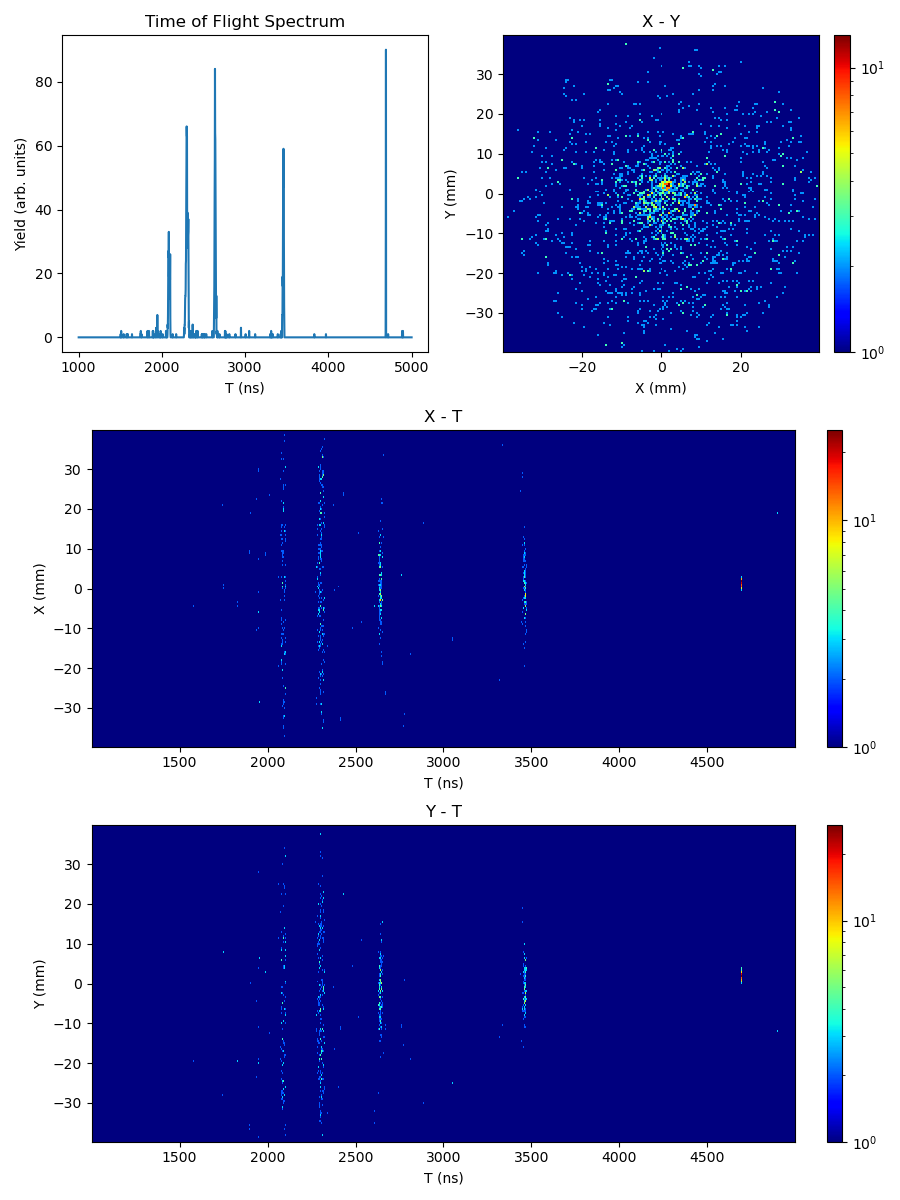

array number_of_hits has channels with zero hits: [0 0 0 0 0]
array number_of_hits has channels with zero hits: [4 0 6 6 4]
array number_of_hits has channels with zero hits: [6 0 6 4 4]


In [3]:
init()
Process()